# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

%matplotlib inline

# Implement layers of the MLP

In [2]:
#layers
class Dense:
    
    def __init__(self, in_size, out_size, reg_lambda = 0.0):
        self.W = np.random.normal(scale = 1, size = (out_size, in_size)) * np.sqrt(2/(in_size + out_size))
        self.b = np.zeros(out_size)
        self.reg_lambda = reg_lambda
        self.final_dW = 0
        self.final_db = 0
        
    def forward(self, x):
        self.x = x
        if np.array(x).shape[0] != self.W.shape[1]:
            print('X is not the same dimention as in_size')
        return(np.dot(self.W,self.x) + self.b)
        #return(dot(self.W, self.x) + self.b)
    
    # честно верим, что эта функция работает правильно
    def get_reg_loss(self): 
        return 0.5 * self.reg_lambda * (np.linalg.norm(self.W, ord='fro') ** 2)
    
    def backward(self, dz, learning_rate = 0.001, mini_batch = False, update = True, len_mini_batch = None):
        self.dW = np.outer(dz,self.x) # OPTIMIZE
        #self.dW = outer_wrap(dz,self.x)
        self.db = dz
        self.dx = np.dot(dz, self.W) # OPTIMIZE
        #self.dx = dot2(dz, self.W) 
        
        if(self.reg_lambda != 0):
            self.dW += self.reg_lambda * self.W
            
        if mini_batch == True:
            self.final_dW += self.dW
            self.final_db += self.db
        
        if update == True:
            if mini_batch == True:
                self.W = self.W - learning_rate * self.final_dW/len_mini_batch
                self.b = self.b - learning_rate * self.final_db/len_mini_batch
                self.final_dW = 0
                self.final_db = 0
            else:
                self.W = self.W - learning_rate * self.dW
                self.b = self.b - learning_rate * self.db
        
        return self.dx

class Dropout:
    def __init__(self, p = 0.5):
        self.p = p
    
    def forward(self, x, train = True):
        if not train:
            self.mask = np.ones(*x.shape)
            return x
        self.mask = ( np.random.rand(*x.shape) > self.p ) / (1.0 - self.p)
        return x * self.mask
        
    def backward(self, dz, lr=0.001):
        return dz * self.mask

# loss
class CrossEntropy:
    
    def forward(self, y_true, y_hat):
        self.y_hat = y_hat + 0.0001
        self.y_true = y_true
        self.loss = - np.sum(self.y_true * np.log(self.y_hat))
        return self.loss
    
    def backward(self):
        dz = - self.y_true/self.y_hat
        return dz

# activations
class Softmax:
    
    def forward(self,x):
        x = x - np.max(x)
        self.p = np.exp(x)/np.sum(np.exp(x))
        return self.p
    
    def backward(self, dz):
        jacobian = np.diag(dz)
        for i in range(len(jacobian)):
            for j in range(len(jacobian)):
                if i == j:
                    jacobian[i][j] = self.p[i] * (1-self.p[j])
                else: 
                    jacobian[i][j] = -self.p[i]*self.p[j]
        return np.matmul(dz,jacobian)
        
    
class ReLu:
    
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz):
        dz[self.x < 0] = 0
        return dz

In [3]:
class Dense:
    def __init__(self, in_size, out_size, rlambda = 0.0):
        self.W = np.random.normal(scale=1, size=(out_size, in_size)) * np.sqrt(2/(out_size + in_size))
        self.b = np.zeros(out_size)
        self.rlambda = rlambda
        
    def forward(self, x):
        self.x = x # запоминаем для обратного прохода
        return np.dot(self.W, x) + self.b
    
    def get_reg_loss(self):
        return 0.5 * self.rlambda * (np.linalg.norm(self.W, ord='fro') ** 2)
    
    def backward(self, dz, lr=0.001):
        # вычисляем градиенты по параметрам (запоминаем их для отладки)
        self.dW = np.outer(dz, self.x)
        self.db = dz
        # вычисляем производную по входу
        self.dx = np.matmul(dz, self.W) 
        # рассчитываем градиенты от регуляризатора
        if(self.rlambda != 0):
            self.dW += self.rlambda * self.W
        # обновляем веса
        self.W = self.W - lr * self.dW
        self.b = self.db - lr * self.db
        # возвращаем dx для продолжения алгоритма
        return self.dx

# Implement classes and function for data preparation and submition

In [4]:
class OneHotEncoder:
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    def transform(self, y):
        return self.transform_mapping[int(y)]
    

def make_submission(X_test, net, fname="my_submission.csv"):
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h = net.forward(X_test[i], train = False)
            y = np.argmax(y_h)
            fout.write("\n{},{}".format(i, int(y)))
            

def compute_acc(X_test, Y_test, net):
    acc = 0.0
    for i in range(X_test.shape[0]):
        y_h = net.forward(X_test[i])
        y = np.argmax(y_h)
        if(y == Y_test[i]):
            acc += 1.0
    return acc / Y_test.shape[0]

# Data preparation

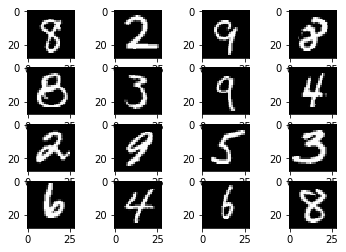

In [5]:
np.random.seed(11)
with open('data_train.pickle', 'rb') as f:
    data = pickle.load(f)
    
encoder = OneHotEncoder()
with open('data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
with open('data_test_no_labels.pickle','rb') as fin:
    test_data = pickle.load(fin)
    
X_train = train_data['data']
X_train = X_train.astype('float')
Y_train = train_data['target']
Y_train_oh = np.array(list(map(lambda x : encoder.transform(x), Y_train)))

X_test = test_data['data']

n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = train_data['data'][np.random.randint(0, X_train.shape[0]),:]
    I = I.reshape((28, 28))
    plt.imshow(I, cmap='gray')

## Normalization

In [6]:
train_x, test_x, train_y_oh, test_y_oh, train_y, test_y = train_test_split(X_train, Y_train_oh, Y_train, test_size = 0.1, stratify = Y_train)


mean = np.mean(train_x, axis = 0)
std = np.std(train_x, axis = 0)

train_x = (train_x - mean)/(std + 0.01)
test_x = (test_x - mean)/(std + 0.01)

# Model implementation

## Stochastic 

In [10]:
class MnistNet:
    
    def __init__(self):
        self.d1_layer = Dense(784,256)
        self.a1_layer = ReLu()
        self.drop1_layer = Dropout(0.5)
        
        self.d2_layer = Dense(256,256)
        self.a2_layer = ReLu()
        self.drop2_layer = Dropout(0.5)
        
        self.d3_layer = Dense(256,10)
        self.a3_layer = Softmax()
        
    def forward(self,x, train = True):
        net = self.d1_layer.forward(x)
        net = self.a1_layer.forward(net)
        net = self.drop1_layer.forward(net, train)
        
        net = self.d2_layer.forward(net)
        net = self.a2_layer.forward(net)
        net = self.drop2_layer.forward(net, train)
        
        net = self.d3_layer.forward(net)
        net = self.a3_layer.forward(net)
        
        return(net)
    
    def backward(self, dz, lr=0.1):
        
        dz = self.a3_layer.backward(dz)
        dz = self.d3_layer.backward(dz, lr)
        
        dz = self.drop2_layer.backward(dz)
        dz = self.a2_layer.backward(dz)
        dz = self.d2_layer.backward(dz, lr)
        
        dz = self.drop1_layer.backward(dz)
        dz = self.a1_layer.backward(dz)
        dz = self.d1_layer.backward(dz, lr)
        
        return dz

## MiniBatch

In [11]:
class MnistNetMiniBatch:
    
    def __init__(self):
        self.d1_layer = Dense(784,512)
        self.a1_layer = ReLu()
        self.drop1_layer = Dropout(0.25)
        
        self.d2_layer = Dense(512,256)
        self.a2_layer = ReLu()
        self.drop2_layer = Dropout(0.25)
        
        self.d3_layer = Dense(256,10)
        self.a3_layer = Softmax()
        
    def forward(self,x, train = True):
        net = self.d1_layer.forward(x)
        net = self.a1_layer.forward(net)
        net = self.drop1_layer.forward(net, train)
        
        net = self.d2_layer.forward(net)
        net = self.a2_layer.forward(net)
        net = self.drop2_layer.forward(net, train)
        
        net = self.d3_layer.forward(net)
        net = self.a3_layer.forward(net)
        
        return(net)
    
    def backward(self, dz, learning_rate = 0.01, mini_batch = True, update = False, len_mini_batch = None):
        
        dz = self.a3_layer.backward(dz)
        dz = self.d3_layer.backward(dz, learning_rate = learning_rate, mini_batch = mini_batch, update = update, len_mini_batch = len_mini_batch)
        
        dz = self.drop2_layer.backward(dz)
        dz = self.a2_layer.backward(dz)
        dz = self.d2_layer.backward(dz, learning_rate = learning_rate, mini_batch = mini_batch, update = update, len_mini_batch = len_mini_batch)
        
        dz = self.drop1_layer.backward(dz)
        dz = self.a1_layer.backward(dz)
        dz = self.d1_layer.backward(dz, learning_rate = learning_rate, mini_batch = mini_batch, update = update, len_mini_batch = len_mini_batch)
        
        return dz

# Learning (stochaistic proved to be better)

In [13]:
loss = CrossEntropy()
net = MnistNet()
lr = 0.001
L_train = []
L_test = []
Acc_train = []
Acc_test = []
for it in range(30):
    
    if it >= 15:
        lr *= 0.7
    
    L_acc = 0.
    sh = list(range(train_x.shape[0]))
    np.random.shuffle(sh)
    
    for i in range(train_x.shape[0]):
        x = train_x[sh[i]]
        y = train_y_oh[sh[i]]
        y_h = net.forward(x)
        L = loss.forward(y, y_h)
        L_acc += L 
        dz = loss.backward()
        dz = net.backward(dz, lr)
    L_acc /= train_y_oh.shape[0]
    L_train.append(L_acc)
    acc = compute_acc(train_x, train_y, net)
    Acc_train.append(acc)
    
    L_e_acc = 0.
    for i in range(test_x.shape[0]):
        x = test_x[i]
        y = test_y_oh[i]
        y_h = net.forward(x)
        L = loss.forward(y, y_h)
        L_e_acc += L
    L_e_acc /= test_y_oh.shape[0]
    L_test.append(L_e_acc)
    acc = compute_acc(test_x, test_y, net)
    Acc_test.append(acc)
    
    print("{} epoch. Train : {} . Test : {}. acc : {} . val_acc: {}".format(it+1, L_acc, L_e_acc, Acc_train[-1], Acc_test[-1]))

1 epoch. Train : 0.5899831559505668 . Test : 0.37156855763303703. acc : 0.8914285714285715 . val_acc: 0.8929523809523809
2 epoch. Train : 0.3405544545431999 . Test : 0.30328652481327617. acc : 0.9138412698412698 . val_acc: 0.9062857142857143
3 epoch. Train : 0.28424921837026323 . Test : 0.2866983513736361. acc : 0.9210158730158731 . val_acc: 0.9158095238095239
4 epoch. Train : 0.2520008983142425 . Test : 0.2536721027127212. acc : 0.9318941798941799 . val_acc: 0.924952380952381
5 epoch. Train : 0.225627131966863 . Test : 0.24554676946360576. acc : 0.9390899470899471 . val_acc: 0.9304761904761905
6 epoch. Train : 0.20758115640662828 . Test : 0.22873378775137465. acc : 0.9402116402116402 . val_acc: 0.9352380952380952
7 epoch. Train : 0.19609914106587908 . Test : 0.2278926131618641. acc : 0.9456084656084656 . val_acc: 0.935047619047619
8 epoch. Train : 0.18774409316564808 . Test : 0.21647417189964493. acc : 0.9486349206349206 . val_acc: 0.9392380952380952
9 epoch. Train : 0.175266159313521

# Plots

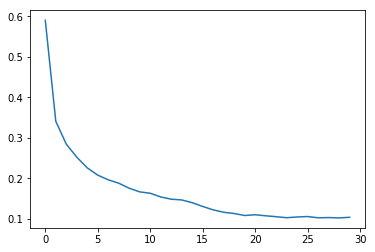

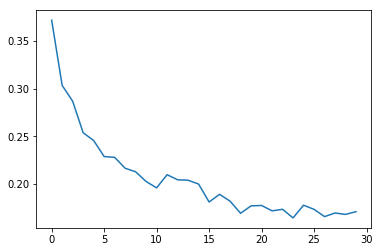

In [14]:
plt.plot(L_train, label="train")
plt.show()
plt.plot(L_test, label="test")
plt.show()

In [15]:
L_e_acc = 0.
for i in range(test_x.shape[0]):
    x = test_x[i]
    y = test_y_oh[i]
    y_h = net.forward(x, train = False)
    L = loss.forward(y, y_h)
    L_e_acc += L
L_e_acc /= test_y_oh.shape[0]
acc = compute_acc(test_x, test_y, net)

print('accuracy:', acc, 'loss:', L_e_acc)

accuracy: 0.9493333333333334 loss: 0.09879096425099994


# Preparing file for Kaggle

In [16]:
X_test = X_test.astype('float')
X_test_norm = (X_test - mean)/(std + 0.0001)
make_submission(X_test_norm, net, fname="submission_test_acc_"+str(np.round(Acc_test[-1],3))+".csv")

# Additional code

In [ ]:
from numba import jit
from numba import cuda
import math

### Tried to write GPU optimized code

In [ ]:
@cuda.jit
def matmul(W, x, res):
    """ W * x
    """
    row, col = cuda.grid(2)
    if row < res.shape[0]:
        tmp = 0.
        for k in range(W.shape[1]):
            tmp += W[row, k] * x[k]
        res[row] = tmp
        
def dot(W,x):
    W_global = cuda.to_device(W)
    x_global = cuda.to_device(x)
    
    res_global_mem = cuda.device_array((W.shape[0]))
    
    threadsperblock = (16, 16)
    blockspergrid_x = int(math.ceil(W.shape[0] / threadsperblock[0]))
    blockspergrid_y = int(math.ceil(x.shape[0] / threadsperblock[1]))
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    # Start the kernel 
    matmul[blockspergrid, threadsperblock](W_global, x_global, res_global_mem)

    # Copy the result back to the host
    res = res_global_mem.copy_to_host()
    
    return res

@cuda.jit
def matmul2(W, z, res):
    """ z * W
    """
    row, col = cuda.grid(2)
    if row < res.shape[0]:
        tmp = 0.
        for k in range(W.shape[0]):
            tmp += W[row, k] * z[k]
        res[row] = tmp
        
def dot2(z,W):
    z_global = cuda.to_device(z)
    W_global_mem = cuda.to_device(W)
    
    res_global_mem2 = cuda.device_array((W.shape[1]))
    
    threadsperblock = (16, 16)
    blockspergrid_x = int(math.ceil(W.shape[1] / threadsperblock[0]))
    blockspergrid_y = int(math.ceil(z.shape[0] / threadsperblock[1]))
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    # Start the kernel 
    matmul2[blockspergrid, threadsperblock](W_global_mem, z_global, res_global_mem2)

    # Copy the result back to the host
    res = res_global_mem2.copy_to_host()
    
    return res

@cuda.jit
def outer(z, x, res):
    """outer
    """
    row, col = cuda.grid(2)
    if row < res.shape[0] and col < res.shape[0]:
        tmp = 0.
        tmp += z[row] * x[col]
        res[row,col] = tmp
        
def outer_wrap(z,x):
    z_global_mem = cuda.to_device(z)
    x_global_mem = cuda.to_device(x)
    
    res_global_mem3 = cuda.device_array((z.shape[0],x.shape[0]))
    
    threadsperblock = (16, 16)
    blockspergrid_x = int(math.ceil(x.shape[0] / threadsperblock[0]))
    blockspergrid_y = int(math.ceil(z.shape[0] / threadsperblock[0]))
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    # Start the kernel 
    outer[blockspergrid, threadsperblock](z_global_mem, x_global_mem, res_global_mem3)

    # Copy the result back to the host
    res = res_global_mem3.copy_to_host()
    
    return res

### Models I used before the best one above

In [8]:
# Опеределение самой сети
class MnistNet:
    def __init__(self):
        self.d1_layer = Dense(784,100)
        self.a1_layer = ReLu()
        self.drop1_layer = Dropout(0.5)
        
        self.d2_layer = Dense(100,50)
        self.a2_layer = ReLu()
        self.drop2_layer = Dropout(0.25)
        
        self.d3_layer = Dense(50,10)
        self.a3_layer = Softmax()
        
    def forward(self, x, train = True):
        net = self.d1_layer.forward(x)
        net = self.a1_layer.forward(net)
        net = self.drop1_layer.forward(net, train)
        
        net = self.d2_layer.forward(net)
        net = self.a2_layer.forward(net)
        net = self.drop2_layer.forward(net, train)
        
        net = self.d3_layer.forward(net)
        net = self.a3_layer.forward(net)
        
        return(net)
    
    def backward(self, dz, lr=0.1):
        
        dz = self.a3_layer.backward(dz)
        dz = self.d3_layer.backward(dz, learning_rate = lr)
        
        dz = self.drop2_layer.backward(dz)
        dz = self.a2_layer.backward(dz)
        dz = self.d2_layer.backward(dz, learning_rate = lr)
        
        dz = self.drop1_layer.backward(dz)
        dz = self.a1_layer.backward(dz)
        dz = self.d1_layer.backward(dz, learning_rate = lr)
        
        return dz
    
class MnistNetMiniBatch:
    def __init__(self):
        self.d1_layer = Dense(784,100)
        self.a1_layer = ReLu()
        self.drop1_layer = Dropout(0.5)
        
        self.d2_layer = Dense(100,50)
        self.a2_layer = ReLu()
        self.drop2_layer = Dropout(0.25)
        
        self.d3_layer = Dense(50,10)
        self.a3_layer = Softmax()
        
    def forward(self,x, train = True):
        net = self.d1_layer.forward(x)
        net = self.a1_layer.forward(net)
        net = self.drop1_layer.forward(net, train)
        
        net = self.d2_layer.forward(net)
        net = self.a2_layer.forward(net)
        net = self.drop2_layer.forward(net, train)
        
        net = self.d3_layer.forward(net)
        net = self.a3_layer.forward(net)
        
        return(net)
    
    def backward(self, dz, learning_rate = 0.01, mini_batch = True, update = False, len_mini_batch = None):
        
        dz = self.a3_layer.backward(dz)
        dz = self.d3_layer.backward(dz, learning_rate = learning_rate, mini_batch = mini_batch, update = update, len_mini_batch = len_mini_batch)
        
        dz = self.drop2_layer.backward(dz)
        dz = self.a2_layer.backward(dz)
        dz = self.d2_layer.backward(dz, learning_rate = learning_rate, mini_batch = mini_batch, update = update, len_mini_batch = len_mini_batch)
        
        dz = self.drop1_layer.backward(dz)
        dz = self.a1_layer.backward(dz)
        dz = self.d1_layer.backward(dz, learning_rate = learning_rate, mini_batch = mini_batch, update = update, len_mini_batch = len_mini_batch)
        
        return dz


0.006999999999999999
0.004899999999999999
0.003429999999999999
0.002400999999999999
0.0016806999999999992
0.0011764899999999994
0.0008235429999999996
0.0005764800999999997
0.00040353606999999974
0.0002824752489999998
0.00019773267429999984
0.00013841287200999988
9.688901040699991e-05
6.782230728489993e-05
4.747561509942995e-05


In [ ]:
loss = CrossEntropy()
net = MnistNetMiniBatch()
learning_rate = 0.01
L_train = []
L_test = []
Acc_train = []
Acc_test = []
len_mini_batch = 128
for it in range(30):
    L_acc = 0.
    sh = list(range(train_x.shape[0])) # больше рандома богу рандома
    np.random.shuffle(sh)
    for i in range(train_x.shape[0]):
        x = train_x[sh[i]]
        y = train_y_oh[sh[i]]
        y_h = net.forward(x)
        L = loss.forward(y, y_h)
        L_acc += L 
        dz = loss.backward()
        if i % len_mini_batch == 0:
            dz = net.backward(dz, learning_rate, update = True, len_mini_batch = len_mini_batch)
        else:
            dz = net.backward(dz, learning_rate)
    L_acc /= train_y_oh.shape[0]
    L_train.append(L_acc)
    acc = compute_acc(train_x, train_y, net)
    Acc_train.append(acc)
    L_e_acc = 0.
    for i in range(test_x.shape[0]):
        x = test_x[i]
        y = test_y_oh[i]
        y_h = net.forward(x)
        L = loss.forward(y, y_h)
        L_e_acc += L
    L_e_acc /= test_y_oh.shape[0]
    L_test.append(L_e_acc)
    acc = compute_acc(test_x, test_y, net)
    Acc_test.append(acc)
    
    learning_rate = learning_rate*0.99
    
    print("{} epoch. Train : {} . Test : {}. acc : {} . val_acc: {}".format(it+1, L_acc, L_e_acc, Acc_train[-1], Acc_test[-1]))